In [4]:
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing of Cifar-10

In [17]:
class Preprocessing:
    img_size = 32
    channels = 3
    num_classes = 10
    num_files = 5
    img_per_file = 10000
    _num_train = num_files * img_per_file
    
    def __init__(self):
        pass
    
    def _unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    # Load a data from file
    def _load(self,file):
        data = self._unpickle(file)
        raw = data[b'data']
        label = np.array(data[b'labels'])
        data_norm = np.array(raw, dtype=float) / 255.0
        data_reshape = data_norm.reshape([-1, self.channels, self.img_size, self.img_size])
        img = data_reshape.transpose([0, 2, 3, 1])
        return img, label
    
    def load_train_data(self):
        train_X = np.zeros([self._num_train, self.img_size, self.img_size, self.channels], dtype=float)
        train_Y = np.zeros([self._num_train], dtype=int)
        temp = 0
        for i in range(self.num_files):
            img, label = self._load("data_batch_" + str(i + 1))
            train_X[temp:temp+img.shape[0], :] = img
            train_Y[temp:temp+img.shape[0]] = label
            temp += img.shape[0]
        return train_X,train_Y,np.eye(self.num_classes, dtype=float)[train_Y]

    def load_test_data(self):
        img, label = self._load("test_batch")
        return img,label,np.eye(self.num_classes, dtype=float)[label]

In [18]:
p = Preprocessing()

In [19]:
a,b,c = p.load_train_data()
d,e,f = p.load_test_data()

In [20]:
print(a.shape,b.shape,c.shape,d.shape,e.shape,f.shape)

(50000, 32, 32, 3) (50000,) (50000, 10) (10000, 32, 32, 3) (10000,) (10000, 10)


In [5]:
# pickle.dump(a,open("train.pkl",'wb'))
# pickle.dump(b,open("train_label.pkl",'wb'))
# pickle.dump(c,open("train_label_1_hot.pkl",'wb'))
# pickle.dump(d,open("test.pkl",'wb'))
# pickle.dump(e,open("test_label.pkl",'wb'))
# pickle.dump(f,open("test_label_1_hot.pkl",'wb'))

train = pickle.load(open("train1.pkl",'rb'))
train_label = pickle.load(open("train1_label.pkl",'rb'))
train_label_1 = pickle.load(open("train1_label_1_hot.pkl",'rb'))
val = pickle.load(open("val.pkl",'rb'))
val_label = pickle.load(open("val_label.pkl",'rb'))
val_label_1 = pickle.load(open("val_label_1_hot.pkl",'rb'))
test = pickle.load(open("test.pkl",'rb'))
test_label = pickle.load(open("test_label.pkl",'rb'))
test_label_1 = pickle.load(open("test_label_1_hot.pkl",'rb'))

#### Splitting Train set in Train/Validation

In [67]:
idx_train = np.random.choice(train.shape[0],45000,replace=False)
idx_val = np.delete(np.arange(50000),idx_train)

In [68]:
val = train[idx_val]
val_label = train_label[idx_val]
val_label_1 = train_label_1[idx_val]
train = train[idx_train]
train_label = train_label[idx_train]
train_label_1 = train_label_1[idx_train]

In [88]:
pickle.dump(train,open("train1.pkl",'wb'))
pickle.dump(train_label,open("train1_label.pkl",'wb'))
pickle.dump(train_label_1,open("train1_label_1_hot.pkl",'wb'))
pickle.dump(val,open("val.pkl",'wb'))
pickle.dump(val_label,open("val_label.pkl",'wb'))
pickle.dump(val_label_1,open("val_label_1_hot.pkl",'wb'))

# Model Designing

In [6]:
img_size = 32
channels = 3
num_classes = 10
img_flat = img_size * img_size * channels
num_filter = 3
conv1_filter = 64
conv2_filter = 128
conv3_filter = 256
conv4_filter = 256
fc1_filter = 1024
fc2_filter = 1024

In [7]:
import tensorflow as tf

In [17]:
def var_weight(shape):
#     return tf.get_variable(shape=shape,initializer=tf.contrib.layers.xavier_initializer())
     return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def var_bias(shape):
    return tf.Variable(tf.constant(0.05, shape=[shape]))

def max_pool(x):
#     x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    return tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], padding='VALID')

def new_conv_layer(x,infilter,channels,outfilters):
    pad_x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    w = var_weight([infilter, infilter, channels, outfilters])
    layer = tf.nn.conv2d(pad_x,w,strides=[1, 1, 1, 1],padding='VALID')
    layer = tf.nn.relu(layer + var_bias(outfilters))
    return layer, w

def flat(x):
    features = x.get_shape()[1:4].num_elements()
    return tf.reshape(x, [-1, features]),features

def new_nn_layer(x,num_in,num_out):
    return tf.nn.relu(tf.matmul(x, var_weight([num_in, num_out])) + var_bias(num_out))

def new_batch_norm(x,size=10,epsilon=1e-3):
    batch_mean, batch_var = tf.nn.moments(x,[0])
    scale = tf.Variable(tf.ones([size]))
    beta = tf.Variable(tf.zeros([size]))
    BN = tf.nn.batch_normalization(x,batch_mean,batch_var,beta,scale,epsilon)
    return(tf.nn.sigmoid(BN))

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, channels], name='x')
y = tf.placeholder(tf.float32, shape=[None, num_classes])
y_cls = tf.argmax(y, dimension=1)

In [27]:
conv1,conv1_w = new_conv_layer(x,num_filter,channels,conv1_filter)
print(conv1)
max1 = max_pool(conv1)
print(max1)
conv2,conv2_w = new_conv_layer(max1,num_filter,conv1_filter,conv2_filter)
print(conv2)
max2 = max_pool(conv2)
print(max2)
# drp1 = tf.nn.dropout(max2, 0.5)
# conv3,conv3_w = new_conv_layer(drp1,num_filter,conv2_filter,conv3_filter)
conv3,conv3_w = new_conv_layer(max2,num_filter,conv2_filter,conv3_filter)
print(conv3)
conv4,conv4_w = new_conv_layer(conv3,num_filter,conv3_filter,conv4_filter)
print(conv4)
max3 = max_pool(conv4)
print(max3)
# drp2 = tf.nn.dropout(max3, 0.5)
# flat1,features = flat(drp2)
flat1,features = flat(max3)
print(flat1,features)
nn1 = new_nn_layer(flat1,features,fc1_filter)
print(nn1)
nn2 = new_nn_layer(nn1,fc2_filter,fc2_filter)
print(nn2)

Tensor("Relu_12:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("MaxPool_6:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("Relu_13:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("MaxPool_7:0", shape=(?, 8, 8, 128), dtype=float32)
Tensor("Relu_14:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("Relu_15:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("MaxPool_8:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("Reshape_8:0", shape=(?, 4096), dtype=float32) 4096
Tensor("Relu_16:0", shape=(?, 1024), dtype=float32)
Tensor("Relu_17:0", shape=(?, 1024), dtype=float32)


In [20]:
pred = new_batch_norm(tf.matmul(nn2, var_weight([fc2_filter, num_classes])) + var_bias(num_classes))

In [40]:
def compute_accuracy(pred,x_t, y_t):
    predict = tf.nn.softmax(pred)
    y_pre = sess.run(predict, feed_dict={x: x_t})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y_t,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run([accuracy,cost], feed_dict={x: x_t, y: y_t})
    return result

In [41]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
opti = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Model Training 

In [23]:
def form_batch(x,x_1,batch_size = 50):
#     img_index = np.random.choice(x.shape[0],batch_size,replace=False)
    img_index = np.random.choice(x.shape[0],batch_size)
    return x[img_index, :, :, :], x_1[img_index, :]

In [34]:
acc,epo,los = [],[],[]

In [58]:
batch_size = 52; no_epoch = 2
with tf.Session() as sess:
    saver = tf.train.Saver()
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./model')
    for i in range(int(train.shape[0]/batch_size) * no_epoch):
        x_batch,y_batch = form_batch(train,train_label_1,batch_size)
        _,loss = sess.run([opti,cost], feed_dict={x: x_batch, y: y_batch})
        if i % int(train.shape[0]/batch_size) == 0: 
            epk = int(i / int(train.shape[0]/batch_size))
            print(epk)
            epo.append(epk)
            x_val,y_val = form_batch(val,val_label_1,1000)
            training,validating = compute_accuracy(pred,x_batch,y_batch),compute_accuracy(pred,x_val,y_val)
            acc.append([training[0],validating[0]])
            los.append([training[1],validating[1]])
            
    saver.save(sess,'./model1')
#     x_test,y_test = form_batch(test,test_label_1,1000)
#     print(compute_accuracy(pred,x_test,y_test))

INFO:tensorflow:Restoring parameters from ./model1
0
1


In [72]:
acc

[[0.11538462, 0.111],
 [0.11538462, 0.085000001],
 [0.46153846, 0.456],
 [0.21153846, 0.082000002],
 [0.55769229, 0.43099999],
 [0.44230768, 0.50999999],
 [0.46153846, 0.55299997],
 [0.65384614, 0.58099997],
 [0.53846157, 0.60500002],
 [0.63461536, 0.64499998],
 [0.67307693, 0.65499997],
 [0.65384614, 0.68000001],
 [0.63461536, 0.69400001],
 [0.59615386, 0.676],
 [0.78846157, 0.73799998],
 [0.67307693, 0.72299999],
 [0.75, 0.73500001],
 [0.73076922, 0.71899998],
 [0.75, 0.722],
 [0.80769229, 0.71499997],
 [0.78846157, 0.73799998],
 [0.80769229, 0.73900002],
 [0.76923078, 0.75400001],
 [0.80769229, 0.74199998],
 [0.75, 0.76099998],
 [0.88461536, 0.75800002],
 [0.80769229, 0.72399998],
 [0.82692307, 0.76800001],
 [0.73076922, 0.75099999],
 [0.84615386, 0.73299998],
 [0.84615386, 0.77100003],
 [0.78846157, 0.755],
 [0.80769229, 0.76599997],
 [0.86538464, 0.76300001],
 [0.88461536, 0.76499999],
 [0.86538464, 0.73900002],
 [0.92307693, 0.76999998],
 [0.84615386, 0.78200001],
 [0.94230771, 0

In [73]:
los

[[2.2876611, 2.3168576],
 [2.348453, 2.3322382],
 [2.0810499, 2.0673735],
 [2.2711098, 2.3234835],
 [2.0390522, 2.0732844],
 [2.0230231, 2.0206869],
 [2.0411568, 1.9902927],
 [1.9474053, 1.966222],
 [1.9387223, 1.9295954],
 [1.9398141, 1.9068582],
 [1.8884463, 1.8880103],
 [1.8707049, 1.8691875],
 [1.891346, 1.8460033],
 [1.8480318, 1.8417282],
 [1.7876446, 1.8136408],
 [1.833645, 1.8050346],
 [1.763939, 1.7888124],
 [1.7990456, 1.7855278],
 [1.7433932, 1.7759824],
 [1.7046977, 1.7672347],
 [1.7147491, 1.7582935],
 [1.7217954, 1.7410111],
 [1.7029213, 1.7353512],
 [1.7013571, 1.7256608],
 [1.693351, 1.7190163],
 [1.6510886, 1.7116092],
 [1.6913216, 1.7278181],
 [1.6572752, 1.6911542],
 [1.6483272, 1.6996919],
 [1.6426753, 1.6989713],
 [1.6322238, 1.6985308],
 [1.6858937, 1.7000517],
 [1.6357986, 1.6847415],
 [1.6164293, 1.680248],
 [1.6213956, 1.6901138],
 [1.6027341, 1.6897156],
 [1.5684898, 1.6705794],
 [1.6134737, 1.6657083],
 [1.5770555, 1.6664302],
 [1.5720365, 1.6666296],
 [1.561

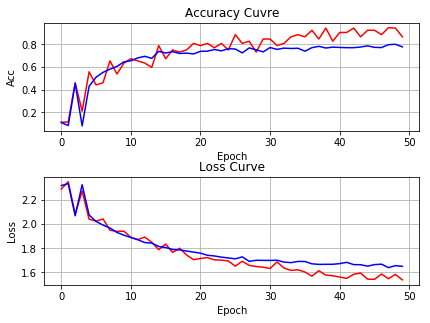

In [106]:
fig = plt.figure()
plt.subplot(2,1,1)
y1 = np.array(acc)[:,0].tolist()
y2 = np.array(acc)[:,1].tolist()
plt.plot(epo, y1,"r")
plt.plot(epo, y2,"b")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Cuvre')
plt.grid(True)
plt.tight_layout(pad=0.5, w_pad=0.6, h_pad=1.5)
plt.subplot(2,1,2)
y1 = np.array(los)[:,0].tolist()
y2 = np.array(los)[:,1].tolist()
plt.plot(epo, y1,"r")
plt.plot(epo, y2,"b")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)

# Test Acc/Loss

In [107]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,'./model1')
    x_test,y_test = form_batch(test,test_label_1,1000)
    print(compute_accuracy(pred,x_test,y_test))

INFO:tensorflow:Restoring parameters from ./model1
[0.77200001, 1.6724793]


# Deconvolution + Unpooling (not only for 10 neurons but for whole neural layer)

In [110]:
ls_grp = test_label == 2
coll_batch = test[ls_grp]
coll_batch_1 = test_label_1[ls_grp]

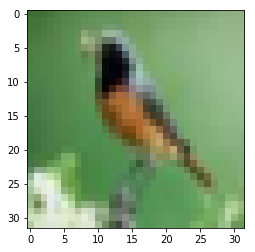

In [111]:
imageToUse = coll_batch[5]
plt.imshow(imageToUse, cmap=plt.cm.RdYlGn)
# plt.show()

In [118]:
active_neuron = np.zeros([conv4_filter,8,8])
def getActivations():
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model')
        for i in range(coll_batch.shape[0]):
            con = sess.run(conv4,feed_dict={x:np.reshape(coll_batch[i],[1,32,32,3])})
#             plot_F(con)
            max_neuron_activated(con)

def max_neuron_activated(conv_layer):
    global active_neuron
    filters = conv_layer.shape[3]
    for i in range(filters):
        layer = np.array(conv_layer[0,:,:,i])
        layer[layer > 0] = 1
        active_neuron[i,:,:] += layer
#     for i in range(filters):
#         id_x,id_y = .nonzero()[0],conv_layer[0,:,:,i].nonzero()[1]
#         for x,y in zip(id_x,id_y):
            
def plot_Filter(units):
    filters = int(units.shape[3])
    plt.figure(1, figsize=(50,50))
    plt.ion() 
    n_columns = 8
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('FeatureMap ' + str(i))
        plt.imshow(units[0,:,:,i], cmap="Greys")

In [119]:
getActivations()

INFO:tensorflow:Restoring parameters from ./model


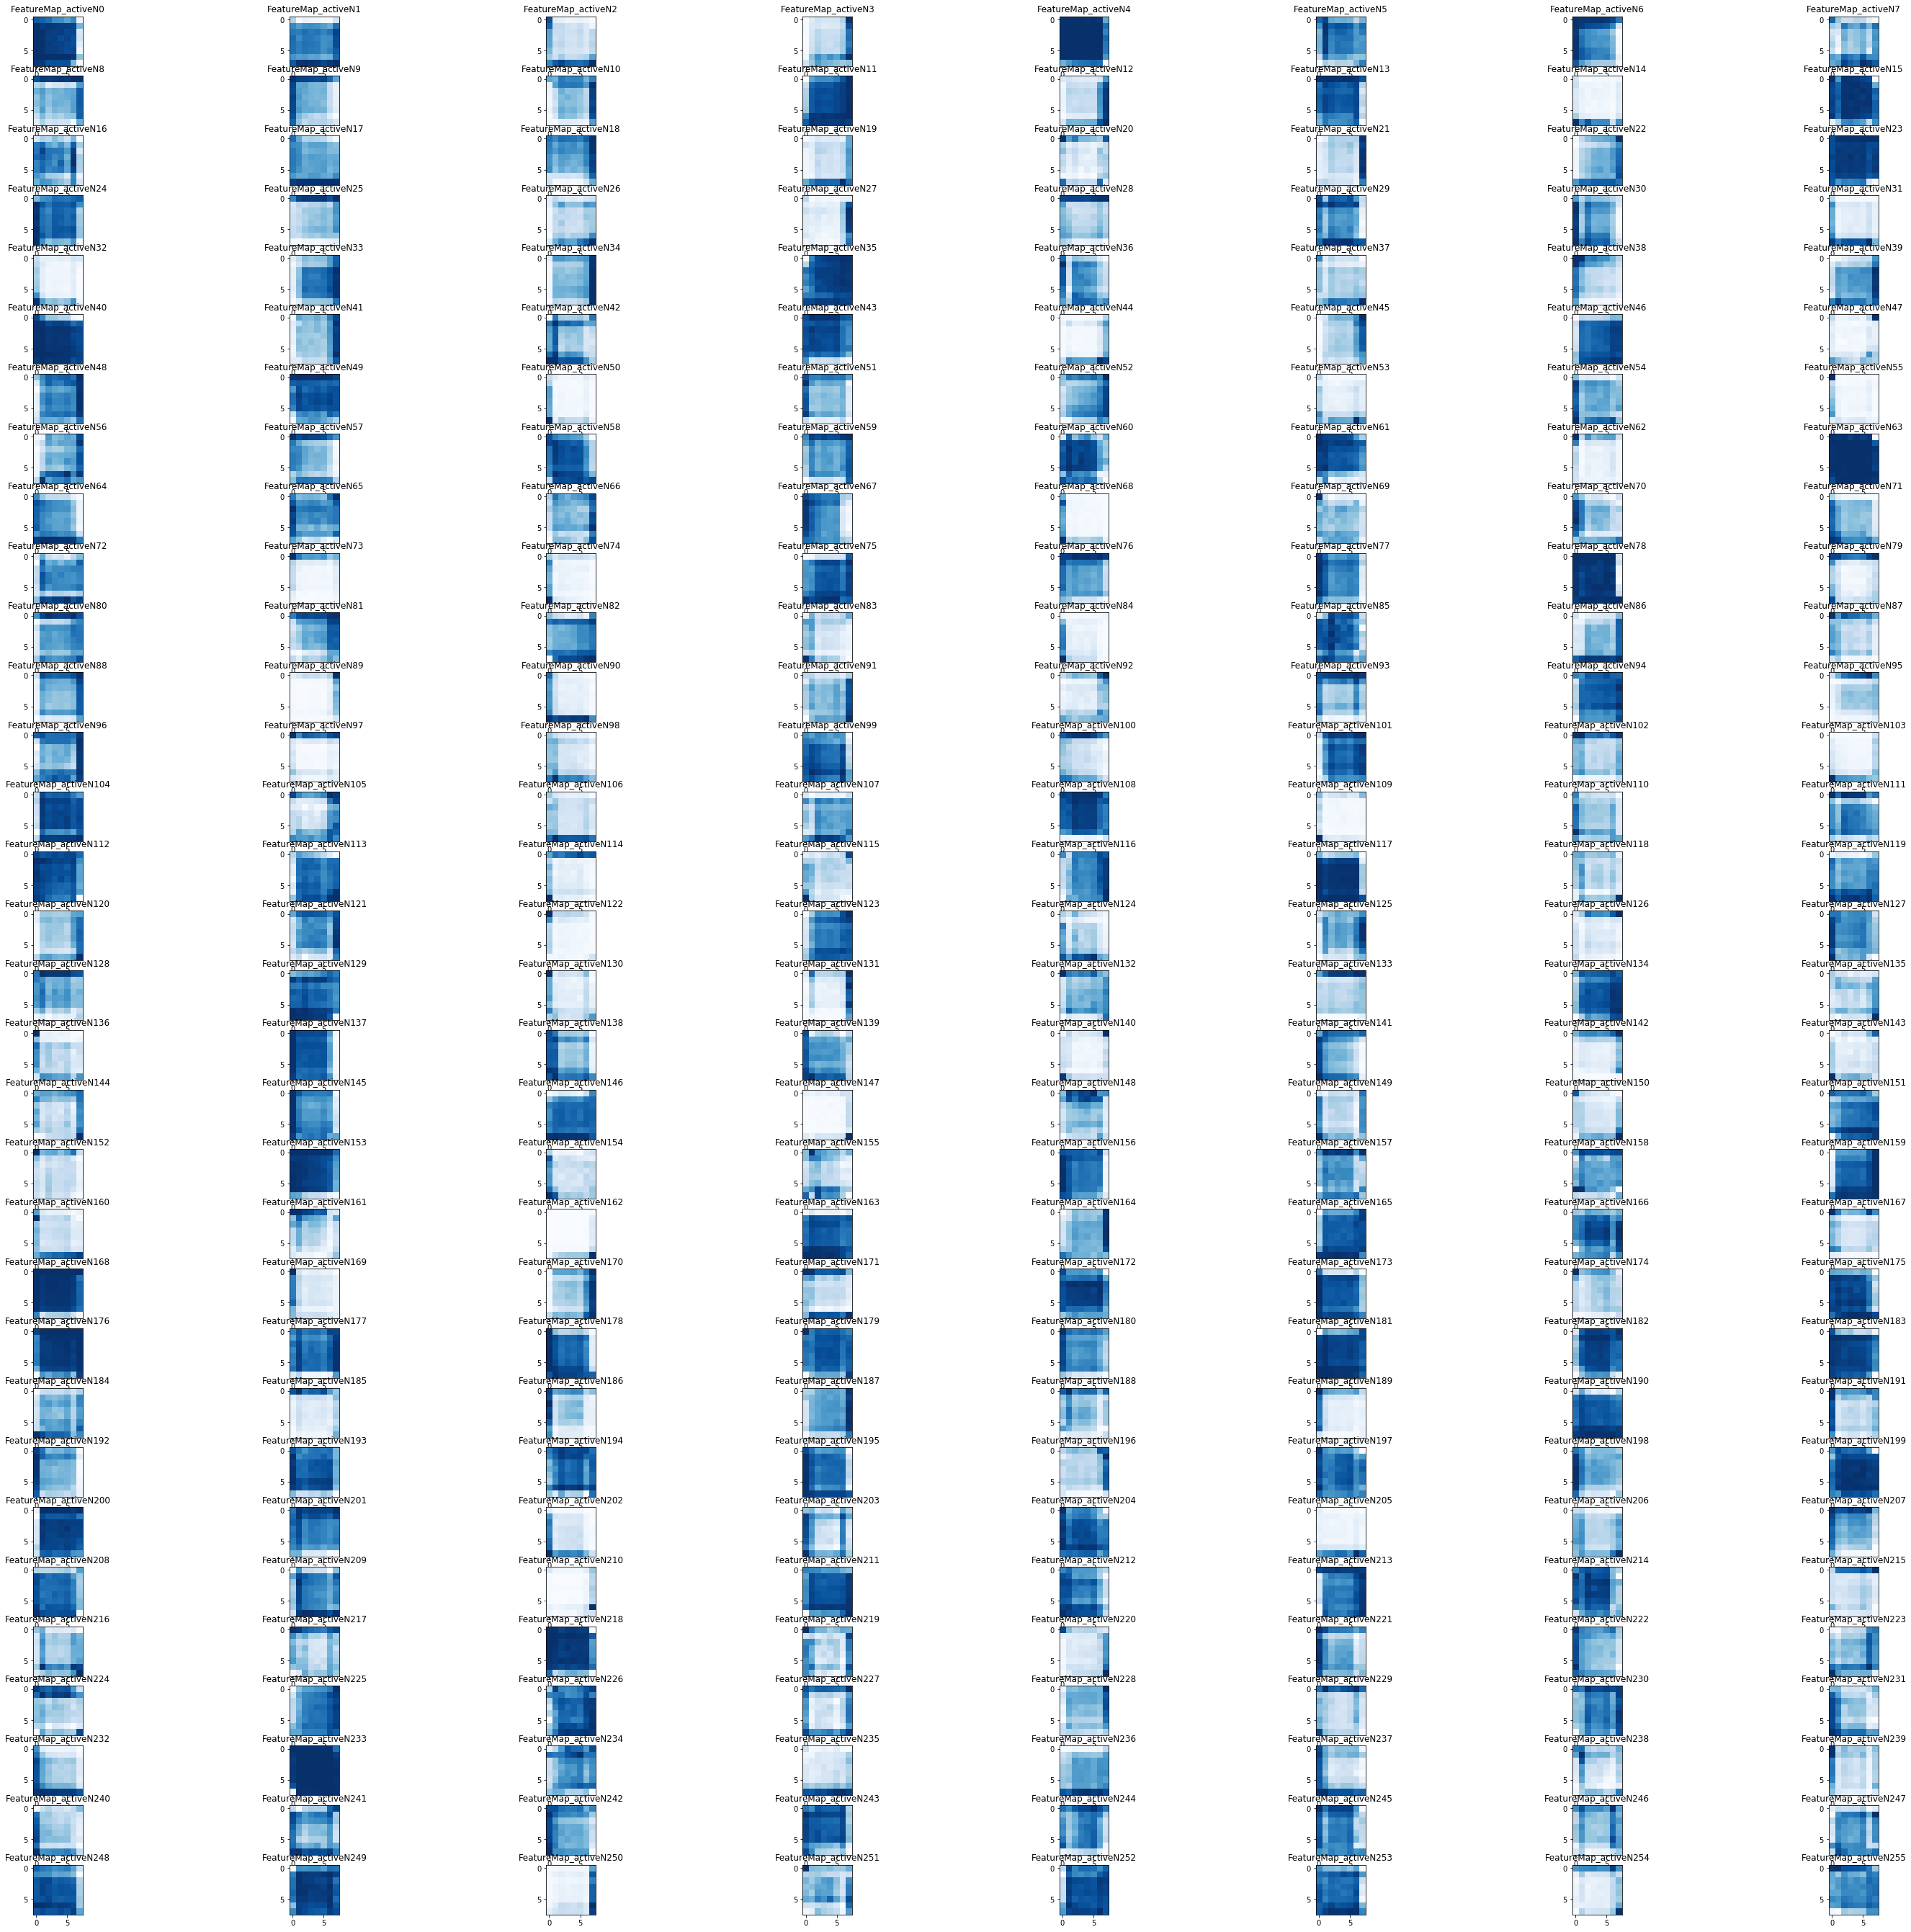

In [124]:
# active_neuron[6]
def plot_frq_kernel(active_neuron):
    filters = active_neuron.shape[0]
    plt.figure(1, figsize=(50,50))
    plt.ion() 
    n_columns = 8
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('FeatureMap_activeN' + str(i))
        plt.imshow(active_neuron[i,:,:], cmap='Blues')
plot_frq_kernel(active_neuron)

In [ ]:
# 189

In [194]:
active_neuron[189]

array([[ 804.,  581.,  350.,  534.,  504.,  512.,  355.,   43.],
       [ 912.,  797.,  793.,  897.,  867.,  788.,  932.,  233.],
       [ 767.,  317.,  484.,  754.,  776.,  693.,  799.,  109.],
       [ 783.,  432.,  586.,  850.,  842.,  776.,  864.,  246.],
       [ 782.,  422.,  631.,  866.,  876.,  813.,  895.,  247.],
       [ 754.,  286.,  453.,  741.,  763.,  632.,  769.,  122.],
       [ 544.,  458.,  494.,  745.,  787.,  637.,  843.,  129.],
       [ 513.,   21.,   45.,   99.,  126.,   91.,  261.,   12.]])

### Layer is selected for analysising

INFO:tensorflow:Restoring parameters from ./model
[[ 3.74534869  2.25498462  1.39463902  3.12187505  0.89676183  1.062814
   5.11055326  0.09742226]
 [ 3.77960181  3.58298612  0.          0.          2.77319813  2.68494248
   2.20470166  1.58581197]
 [ 0.          1.00565946  1.92860723  2.65953684  2.74658895  5.05171394
   1.1470238   4.30620766]
 [ 4.44793892  0.54043573  1.69294786  6.2926383   5.29842472  3.47396469
   0.          2.47102475]
 [ 1.06563485  0.          0.60870683  5.03534126  2.15017319  4.26088762
   0.59768397  5.95633411]
 [ 0.38608104  0.02224236  2.74477506  3.77792454  3.31253695  7.14899778
   4.3875351   0.90992951]
 [ 2.0222075   0.          0.          6.139328    0.          6.01841307
   0.          0.22308283]
 [ 0.94657356  0.          0.          2.10470057  1.04113829  3.88632178
   0.48416167  1.95484209]]


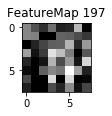

In [123]:
def visual_conv4(i):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model')
        con = sess.run(conv4,feed_dict={x:np.reshape(coll_batch[i],[1,32,32,3])})
        plt.figure(1, figsize=(50,50))
        n_columns = 8
        n_rows = math.ceil(con.shape[3] / n_columns) + 1
        plt.subplot(n_rows, n_columns, 2)
        plt.title('FeatureMap ' + str(i))
        plt.imshow(con[0,:,:,i], cmap='gray')
        print(con[0,:,:,i])
visual_conv4(197)

In [17]:
deconv4 = tf.nn.conv2d_transpose(tf.reshape(conv4[0,:,:,189], [-1, 8,8,1]),tf.reshape(conv4_w[:,:,:,189],[3,3,256,1]),
                                 output_shape=tf.stack([1, 8, 8, conv3_filter]),strides=[1, 1, 1, 1],padding='SAME')

### These are not filters but feature maps

INFO:tensorflow:Restoring parameters from ./model


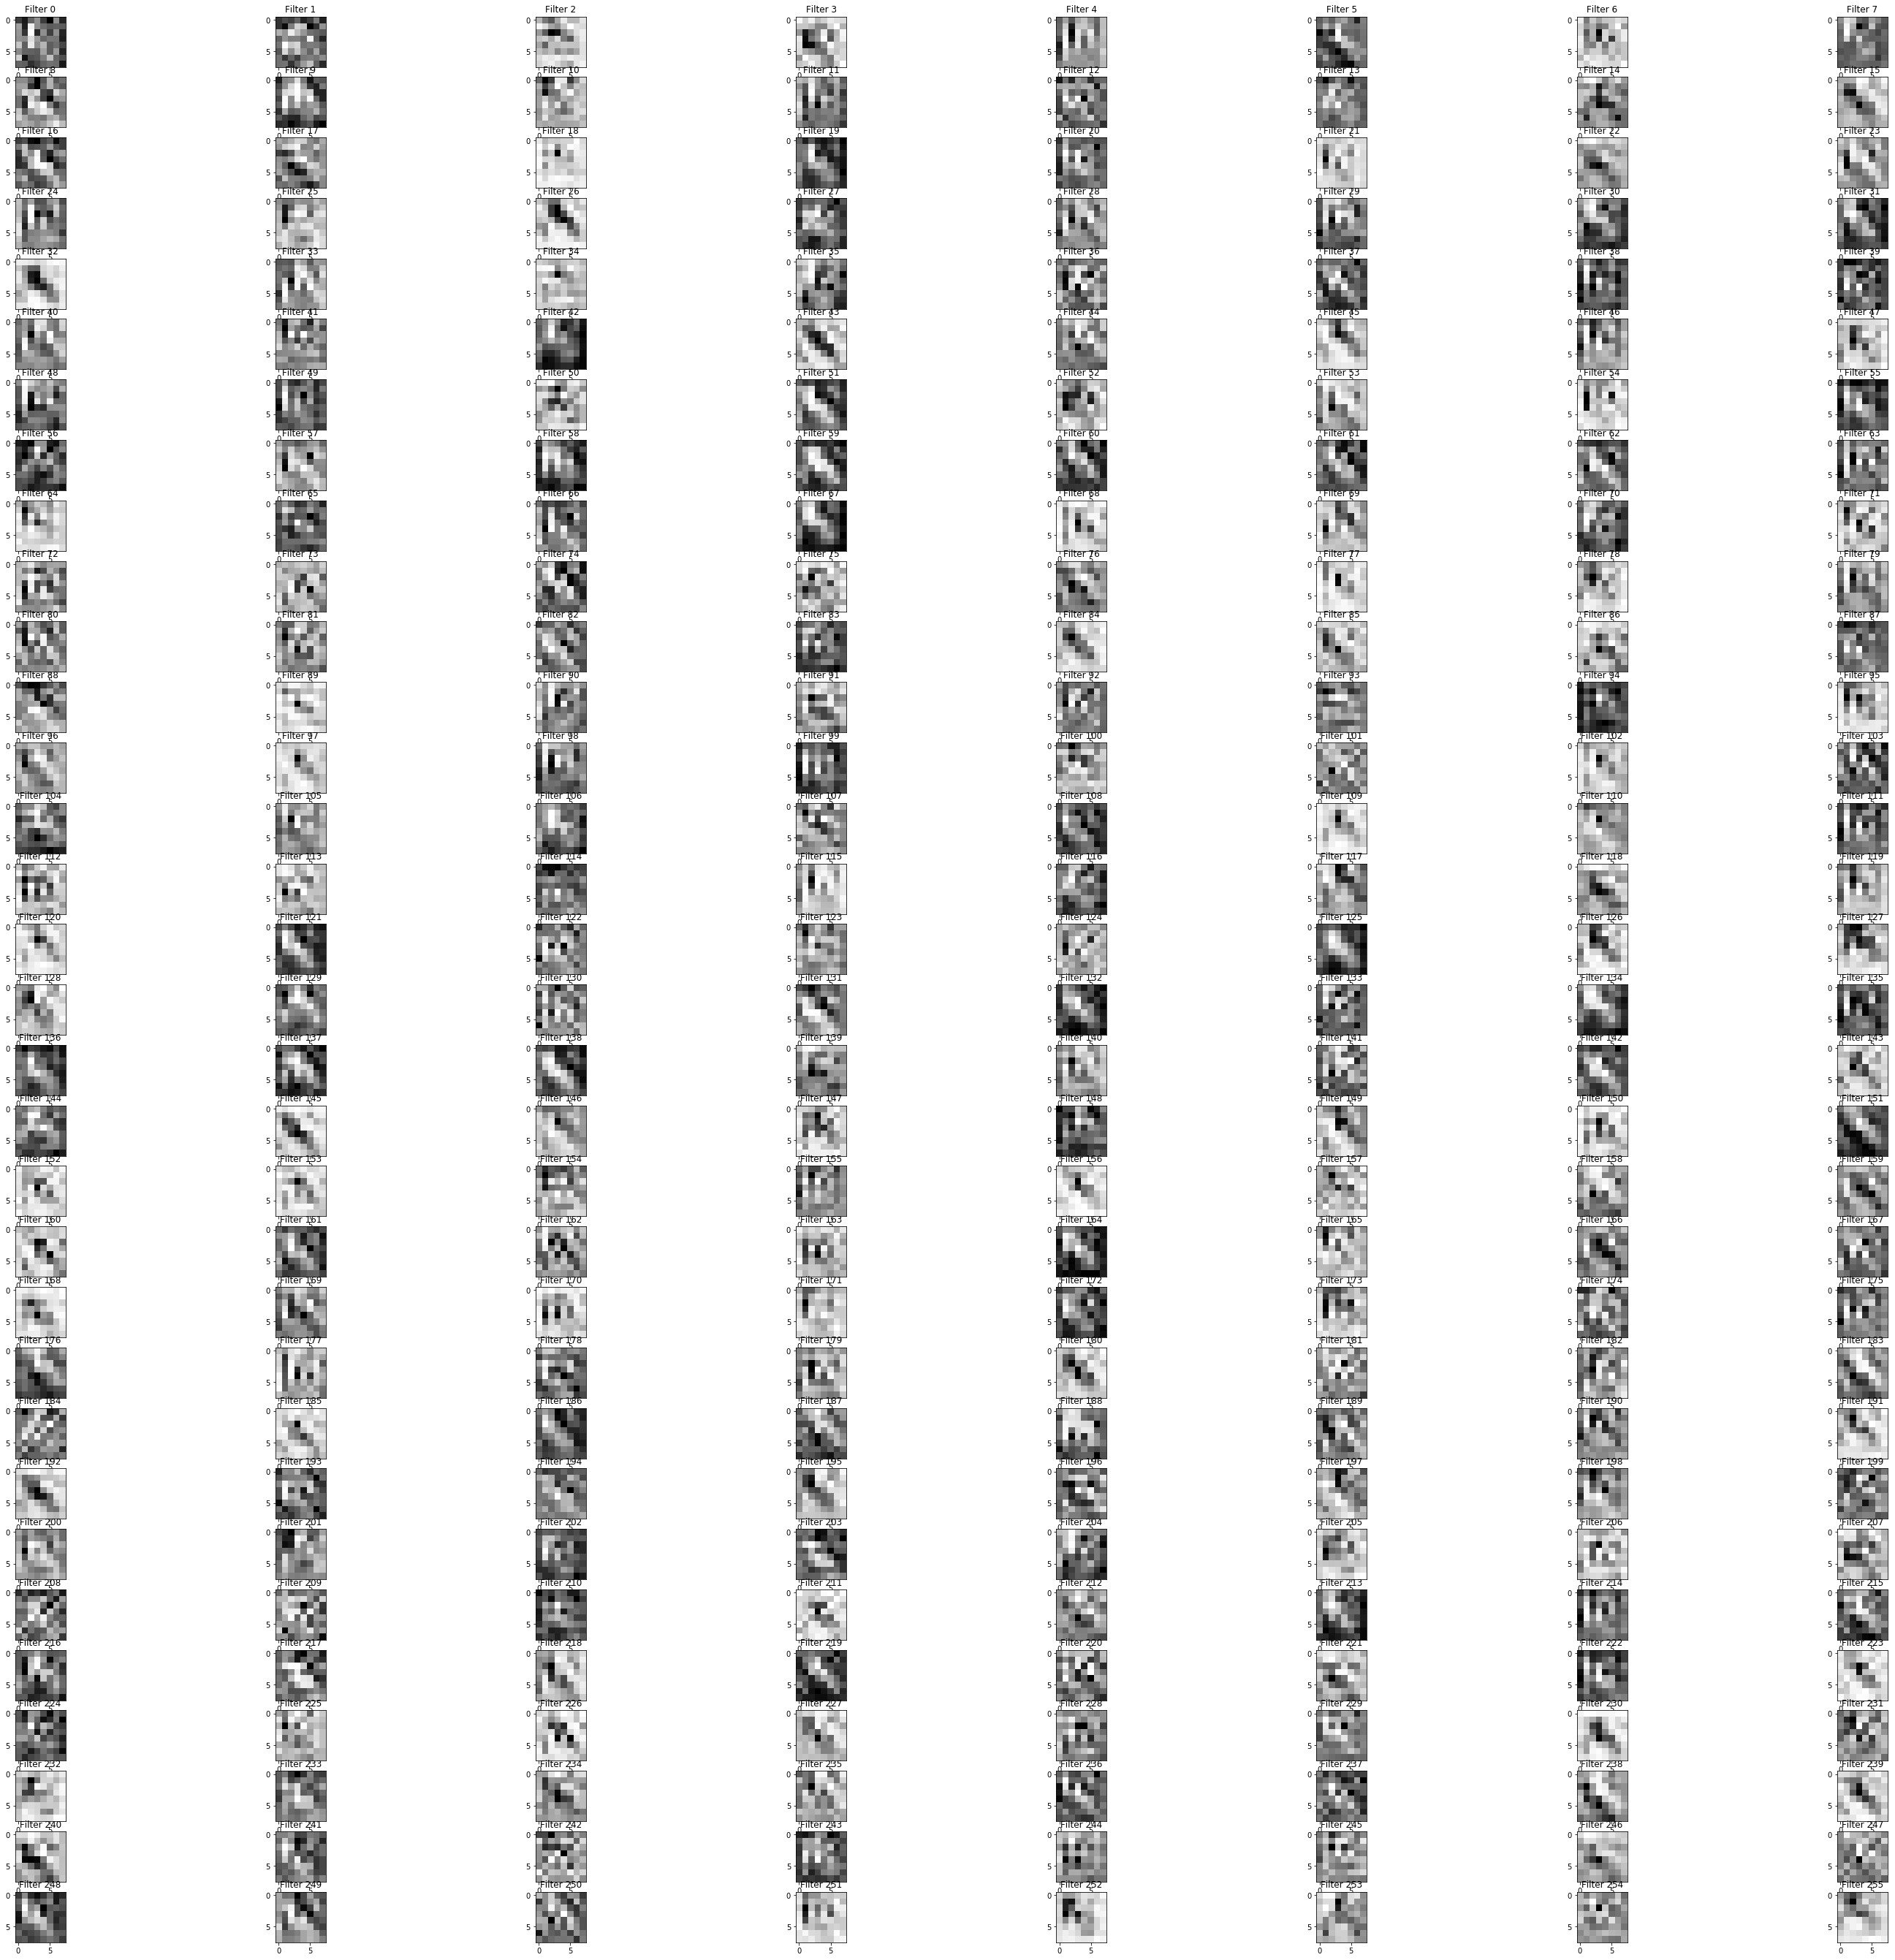

In [18]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,'./model')
    dconvx3,convx4,convx4_w = sess.run([deconv4,conv4,conv4_w],feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})
    plot_Filter(dconvx3)

In [19]:
def unpooling2():
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model')
        current_conv,mimic_conv = sess.run([deconv3,conv2],feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})
        approx_conv = np.zeros(mimic_conv.shape)
        for k in range(mimic_conv.shape[3]):
            conv_filtr = mimic_conv[0,:,:,k]
            cord,id_x,id_y = 0,0,0
            for i in range(0,mimic_conv.shape[1],2):
                for j in range(0,mimic_conv.shape[1],2):
#                     print(conv_filtr[i:i+2,j:j+2])
                    cord = np.argmax(conv_filtr[i:i+2,j:j+2],axis=0)                
                    approx_conv[0,i+cord[0],j+cord[1],k] = current_conv[0,id_x,id_y,k]
                    id_y += 1
                id_x += 1
                id_y = 0
        return approx_conv
    
def unpooling1():
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model')
        current_conv,mimic_conv = sess.run([deconv2,conv1],feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})
        approx_conv = np.zeros(mimic_conv.shape)
        for k in range(mimic_conv.shape[3]):
            conv_filtr = mimic_conv[0,:,:,k]
            cord,id_x,id_y = 0,0,0
            for i in range(0,mimic_conv.shape[1],2):
                for j in range(0,mimic_conv.shape[1],2):
                    cord = np.argmax(conv_filtr[i:i+2,j:j+2],axis=0)        
#                     print(approx_conv[0,i+cord[0],j+cord[1],k])
                    approx_conv[0,i+cord[0],j+cord[1],k] = current_conv[0,id_x,id_y,k]
                    id_y += 1
                id_x += 1
                id_y = 0
        return approx_conv

In [20]:
deconv4 = tf.nn.conv2d_transpose(tf.reshape(conv4[0,:,:,189], [-1, 8,8,1]),tf.reshape(conv4_w[:,:,:,189],[3,3,256,1]),
                                 output_shape=tf.stack([1, 8, 8, conv3_filter]),strides=[1, 1, 1, 1],padding='SAME')
print(deconv4)
deconv3 = tf.nn.conv2d_transpose(deconv4,conv3_w,output_shape=tf.stack([1, 8, 8, conv2_filter]),
                                strides=[1, 1, 1, 1],padding='SAME')
print(deconv3)
deconv2 = tf.nn.conv2d_transpose(tf.cast(unpooling2(), tf.float32),conv2_w,output_shape=tf.stack([1, 16, 16, conv1_filter]),
                                strides=[1, 1, 1, 1],padding='SAME')
print(deconv2)
deconv1 = tf.nn.conv2d_transpose(tf.cast(unpooling1(), tf.float32),conv1_w,output_shape=tf.stack([1, 32, 32, channels]),
                                strides=[1, 1, 1, 1],padding='SAME')
print(deconv1)

Tensor("conv2d_transpose_1:0", shape=(1, 8, 8, 256), dtype=float32)
Tensor("conv2d_transpose_2:0", shape=(1, 8, 8, 128), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model
Tensor("conv2d_transpose_3:0", shape=(1, 16, 16, 64), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model
Tensor("conv2d_transpose_4:0", shape=(1, 32, 32, 3), dtype=float32)


In [21]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,'./model')
    image_visual = sess.run(deconv1,feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})

INFO:tensorflow:Restoring parameters from ./model


In [53]:
def plot_image_visual(active_neuron):
    filters = active_neuron.shape[3]
    plt.figure(1, figsize=(50,50))
    plt.ion() 
    n_columns = 4
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Image_Channel ' + str(i))
        plt.imshow(active_neuron[0,:,:,i], cmap='gray')

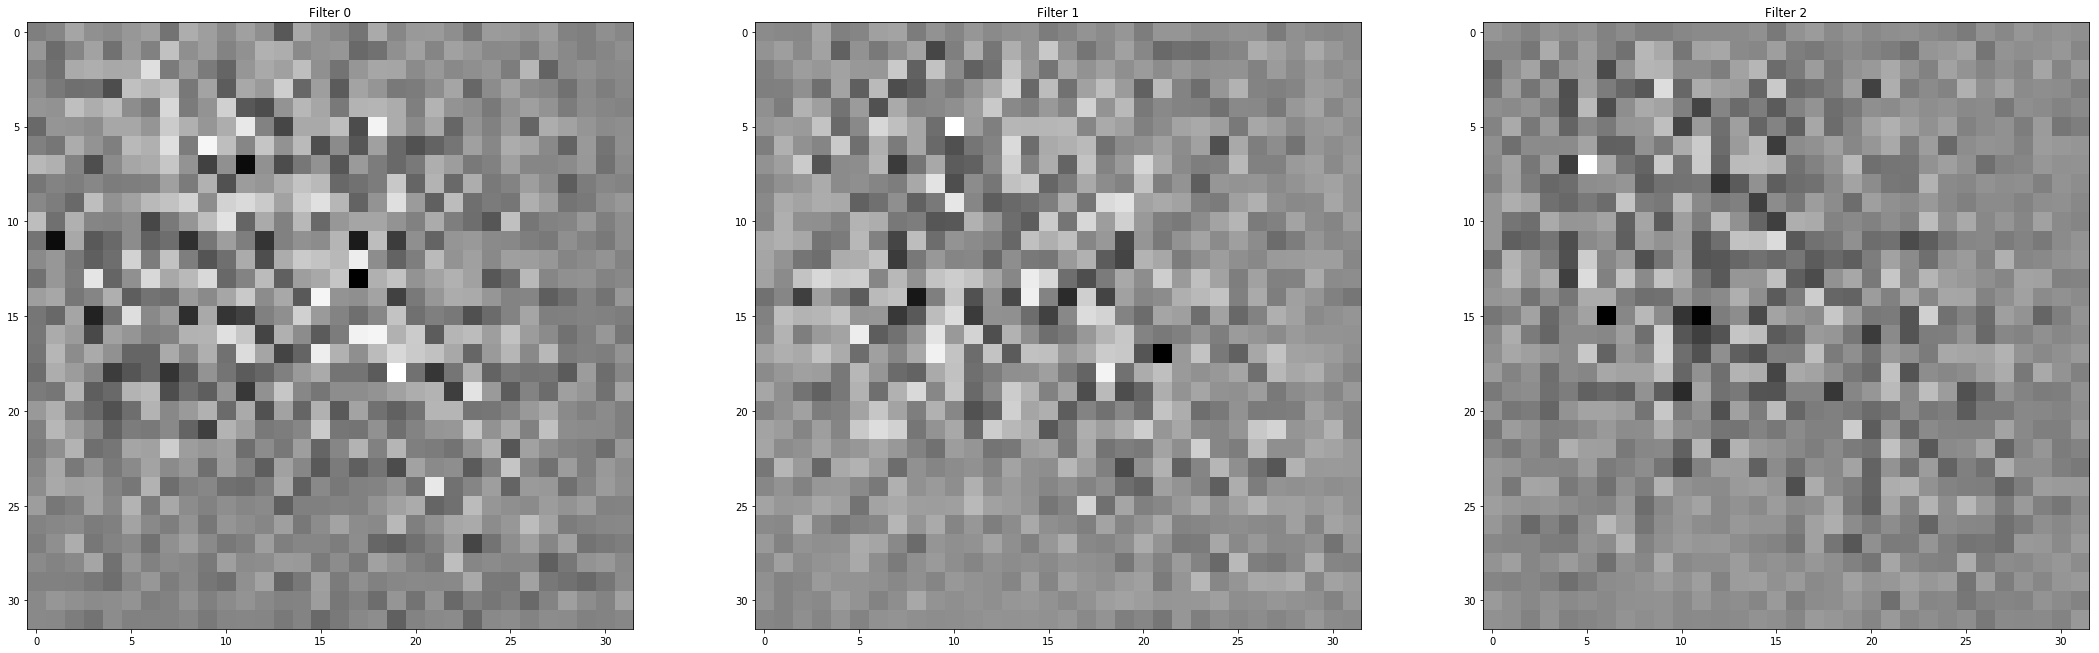

In [54]:
plot_image_visual(image_visual)

In [43]:
# print(conv4_w[:,:,:,189])
# print(conv4[0,:,:,189])
# print(tf.reshape(conv4[0,:,:,189], [-1, 8,8,1]))
# print(tf.reshape(conv4_w[:,:,:,189],[3,3,256,1]))

# Gradient Visualization

In [55]:
def gradunpooling2():
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model')
        current_conv,mimic_conv = sess.run([gradconv3,conv2],feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})
        approx_conv = np.zeros(mimic_conv.shape)
        for k in range(mimic_conv.shape[3]):
            conv_filtr = mimic_conv[0,:,:,k]
            cord,id_x,id_y = 0,0,0
            for i in range(0,mimic_conv.shape[1],2):
                for j in range(0,mimic_conv.shape[1],2):
                    cord = np.argmax(conv_filtr[i:i+2,j:j+2],axis=0)                
                    approx_conv[0,i+cord[0],j+cord[1],k] = current_conv[0,id_x,id_y,k]
                    id_y += 1
                id_x += 1
                id_y = 0
        return approx_conv
    
def gradunpooling1():
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model')
        current_conv,mimic_conv = sess.run([gradconv2,conv1],feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})
        approx_conv = np.zeros(mimic_conv.shape)
        for k in range(mimic_conv.shape[3]):
            conv_filtr = mimic_conv[0,:,:,k]
            cord,id_x,id_y = 0,0,0
            for i in range(0,mimic_conv.shape[1],2):
                for j in range(0,mimic_conv.shape[1],2):
                    cord = np.argmax(conv_filtr[i:i+2,j:j+2],axis=0)        
                    approx_conv[0,i+cord[0],j+cord[1],k] = current_conv[0,id_x,id_y,k]
                    id_y += 1
                id_x += 1
                id_y = 0

                return approx_conv

In [88]:
gradconv4 = tf.nn.conv2d_backprop_input(tf.stack([1, 8, 8, conv3_filter]),tf.reshape(conv4_w[:,:,:,120],[3,3,256,1]),
                                        out_backprop=tf.reshape(conv4[0,:,:,200], [-1, 8,8,1]),
                                        strides=[1, 1, 1, 1],padding='SAME')
print(gradconv4)
gradconv3 = tf.nn.conv2d_backprop_input(tf.stack([1, 8, 8, conv2_filter]),conv3_w,
                                        out_backprop=gradconv4,
                                        strides=[1, 1, 1, 1],padding='SAME')
print(gradconv3)
gradconv2 = tf.nn.conv2d_backprop_input(tf.stack([1, 16, 16, conv1_filter]),conv2_w,
                                        out_backprop=tf.cast(gradunpooling2(), tf.float32),
                                        strides=[1, 1, 1, 1],padding='SAME')
print(gradconv2)
gradconv1 = tf.nn.conv2d_backprop_input(tf.stack([1, 32, 32, channels]),conv1_w,
                                        out_backprop=tf.cast(gradunpooling1(), tf.float32),
                                        strides=[1, 1, 1, 1],padding='SAME')
print(gradconv1)

Tensor("Conv2DBackpropInput_15:0", shape=(1, 8, 8, 256), dtype=float32)
Tensor("Conv2DBackpropInput_16:0", shape=(1, 8, 8, 128), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model
Tensor("Conv2DBackpropInput_17:0", shape=(1, 16, 16, 64), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model
Tensor("Conv2DBackpropInput_18:0", shape=(1, 32, 32, 3), dtype=float32)


In [89]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,'./model')
    grad_image_visual = sess.run(gradconv1,feed_dict={x:np.reshape(coll_batch[5],[1,32,32,3])})

INFO:tensorflow:Restoring parameters from ./model


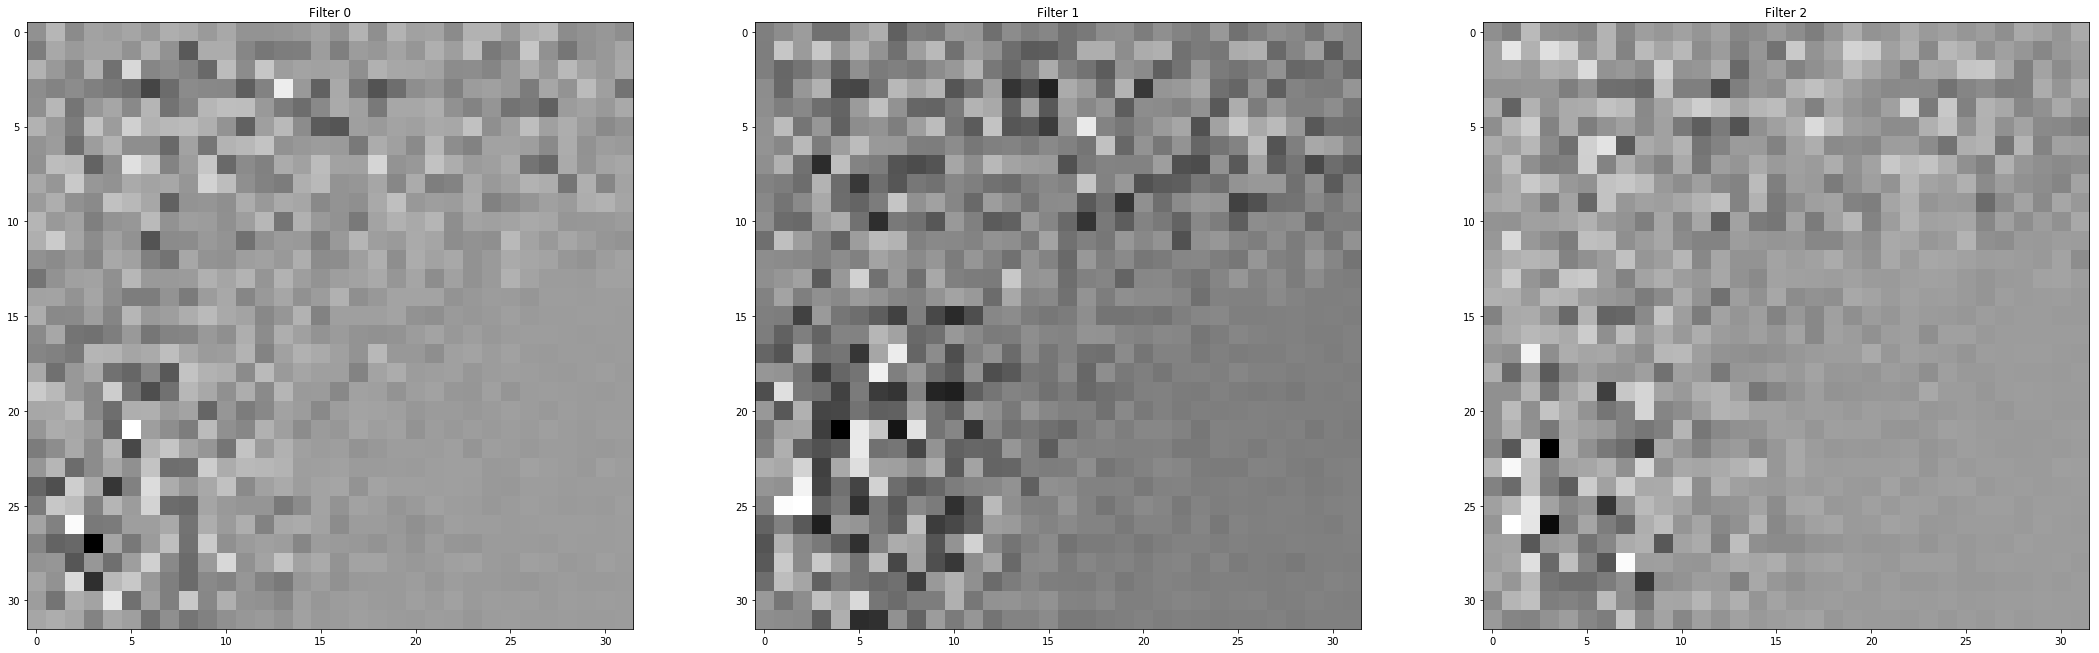

In [90]:
plot_image_visual(grad_image_visual)

INFO:tensorflow:Restoring parameters from ./model
[[ 0.          0.          0.26289779  0.20612724  0.          0.
   0.15440537  0.        ]
 [ 0.          0.08365498  0.550345    0.52406633  0.43332034  0.2342803
   0.36794949  0.08863012]
 [ 0.          0.06272166  0.64006323  0.50697392  0.67310554  0.
   0.05459101  0.        ]
 [ 0.          0.          0.34955215  0.          0.          0.
   0.19271509  0.        ]
 [ 0.          0.          0.41934025  0.          0.          0.          0.
   0.        ]
 [ 0.20501722  0.          0.16506442  0.          0.05527518  0.          0.
   0.        ]
 [ 0.28160003  0.14549376  0.36582458  0.1136627   0.10701565  0.
   0.28828433  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        ]]


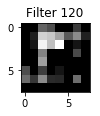

In [87]:
visual_conv4(120)

# 8 * 8 Grid for conv1 filters

In [109]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,'./model')
    filter_conv_1 =  sess.run(conv1_w)

INFO:tensorflow:Restoring parameters from ./model


In [110]:
filter_conv_1.shape

(3, 3, 3, 64)

In [111]:
filt1 = np.transpose(filter_conv_1,[3,0,1,2])

In [112]:
filt1.shape

(64, 3, 3, 3)

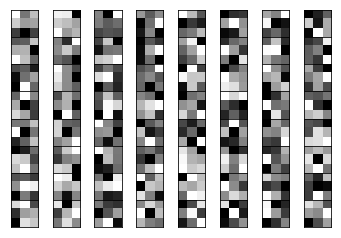

In [159]:
fig = plt.figure()

for i in range(64):
    plt.subplot(8,8,i+1).set_aspect('equal')
    plt.imshow(filt1[i,:,:,0], interpolation="nearest", cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)

# No of Parameters And  Neurons

In [126]:
'No of Weights'                                           'Not counted'
'Conv1        Conv2          Conv3           Conv4           Flatten         NN1             NN2'
                                                            '4*4*256' 
'3*3*3*64' + '3*3*64*128' + '3*3*128*256' + '3*3*128*256'       +       '4*4*256*1024' +  '1024 * 1024'      "Weights"
"64"          "128"          "256"        +  "256"                        "1024"           "1024"            "Bias"

In [ ]:
'No of Neurons'
                                                         'Input neuron'
'3*3*3*64' + '3*3*64*128' + '3*3*128*256' + '3*3*128*256' + '4*4*256'  +     "1024"    +   '1024'   

# Batch Normalization

In [ ]:
"Batch normalization increases the acc by  8-9% on validation Set "
"Previous acc without batch normalization is 66% after applying it's around 75-76%"

# Data Augmentation

In [ ]:
'Small amount of data augmentation done to increase Acc to 80%'

# Keras train

In [24]:
batch_size = 52
num_classes = 10
epochs = 30

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras

In [30]:
def keras_mod():
    model = Sequential()
    model.add(Conv2D(64, (3, 3),padding='same',input_shape=train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    opt = keras.optimizers.Adamax(lr=1e-4)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model
# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
cnn_n = keras_mod()

In [35]:
cnn = cnn_n.fit(train, train_label_1, batch_size=batch_size, epochs=epochs, validation_data=(val,val_label_1),shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 35s - loss: 0.3930 - acc: 0.8629 - val_loss: 0.6609 - val_acc: 0.7792
Epoch 2/10
45000/45000 [==============================] - 33s - loss: 0.3725 - acc: 0.8707 - val_loss: 0.6259 - val_acc: 0.7896
Epoch 3/10
45000/45000 [==============================] - 36s - loss: 0.3537 - acc: 0.8764 - val_loss: 0.6407 - val_acc: 0.7868
Epoch 4/10
45000/45000 [==============================] - 36s - loss: 0.3304 - acc: 0.8844 - val_loss: 0.6032 - val_acc: 0.7990
Epoch 5/10
45000/45000 [==============================] - 36s - loss: 0.3137 - acc: 0.8898 - val_loss: 0.6430 - val_acc: 0.7886
Epoch 6/10
45000/45000 [==============================] - 36s - loss: 0.3005 - acc: 0.8940 - val_loss: 0.6243 - val_acc: 0.7964
Epoch 7/10
45000/45000 [==============================] - 31s - loss: 0.2817 - acc: 0.9030 - val_loss: 0.5926 - val_acc: 0.8028
Epoch 8/10
45000/45000 [==============================]

In [27]:
cnn_n.save('my_model.h5')

In [47]:
cnn_n.save('my_model1.h5')

In [34]:
cnn_n.save('my_model2.h5')

In [48]:
cnn = cnn_n.fit(train, train_label_1, batch_size=batch_size, epochs=epochs, validation_data=(val,val_label_1),shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 32s - loss: 0.2265 - acc: 0.9207 - val_loss: 0.6573 - val_acc: 0.7934
Epoch 2/10
45000/45000 [==============================] - 31s - loss: 0.2122 - acc: 0.9257 - val_loss: 0.6472 - val_acc: 0.7944
Epoch 3/10
45000/45000 [==============================] - 31s - loss: 0.2030 - acc: 0.9291 - val_loss: 0.6280 - val_acc: 0.8046
Epoch 4/10
45000/45000 [==============================] - 32s - loss: 0.1945 - acc: 0.9322 - val_loss: 0.6869 - val_acc: 0.7954
Epoch 5/10
45000/45000 [==============================] - 32s - loss: 0.1804 - acc: 0.9364 - val_loss: 0.6536 - val_acc: 0.7956
Epoch 6/10
45000/45000 [==============================] - 32s - loss: 0.1696 - acc: 0.9405 - val_loss: 0.6580 - val_acc: 0.7978
Epoch 7/10
45000/45000 [==============================] - 32s - loss: 0.1646 - acc: 0.9426 - val_loss: 0.6519 - val_acc: 0.8060
Epoch 8/10
45000/45000 [==============================]

In [49]:
scores = cnn_n.evaluate(test, test_label_1, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.93%
